In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Remap label values to bins of score

**Current Labels & Coresponding Movie Score by User:**

```score: label value```
```{0.5: 0,
 1.0: 1,
 1.5: 2,
 2.0: 3,
 2.5: 4,
 3.0: 5,
 3.5: 6,
 4.0: 7,
 4.5: 8,
 5.0: 9}```

 **Remap to:** 
 ```{0.5 to 3.5 inclusive: 0 ; 4 to 5 inclusive: 1} ```

In [ ]:
# Load all data
X_train_trf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_train_trf1_v3.csv')
X_val_trf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_val_trf1_v3.csv')
X_test_trf1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_test_trf1_v3.csv')


In [ ]:
movielist = pd.concat([X_train_trf1.loc[:,['primaryTitle', 'movieId_ori','movieId']],
           X_val_trf1.loc[:,['primaryTitle', 'movieId_ori','movieId']],
           X_test_trf1.loc[:,['primaryTitle', 'movieId_ori','movieId']]
], axis = 0).drop_duplicates()

In [ ]:
userlist = pd.concat([X_train_trf1.loc[:,['userId', 'userId_ori']],
           X_val_trf1.loc[:,['userId', 'userId_ori']],
           X_test_trf1.loc[:,['userId', 'userId_ori']]
], axis = 0).drop_duplicates()

userlist 

,userId,userId_ori
0,0.758627,123711
1,0.176422,30111
2,0.633602,103611
3,0.191045,32462
4,0.600113,98227
...,...,...
650,0.572919,93855
667,0.408931,67491
668,0.894942,145626
695,0.186778,31776


In [ ]:
for i in [X_train_trf1,X_val_trf1,X_test_trf1]:
  print(i.shape)

X_test_complete = X_test_trf1.loc[:,['primaryTitle', 'userId_ori',
                                     'userId']]

for i in [X_train_trf1,X_val_trf1,X_test_trf1]:
  i.drop(['rating_month__1',
 'rating_month__2',
 'rating_month__3',
 'rating_month__4',
 'rating_month__5',
 'rating_month__6',
 'rating_month__7',
 'rating_month__8',
 'rating_month__9',
 'rating_month__10',
 'rating_month__11',
 'rating_month__12',
 'rating_year',
 'primaryTitle',
 'movieId_ori',
 'userId_ori'], axis=1, inplace = True)

#X_train_trf1 = X_train_trf1.to_numpy()
#X_val_trf1 = X_val_trf1.to_numpy()
#X_test_trf1 = X_test_trf1.to_numpy() 

y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_train_nn_v3.csv').to_numpy().flatten()
y_val= pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_val_nn_v3.csv').to_numpy().flatten()
y_test= pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_test_nn_v3.csv').to_numpy().flatten()

# Convert 9bins to 2bins func
# index 0 to 6: movie scores given by user, where 0:0.5, 1:1, 2:1.5, 3:2, 4:2.5, 5: 3,  
def nineToTwoBins(y_dataset):
    y_dataset = (y_dataset >= 4).astype(int)
    return y_dataset

(232599, 43)
(41047, 43)
(68433, 43)


In [ ]:
X_test_complete.shape

In [ ]:
for i in [X_train_trf1,X_val_trf1,X_test_trf1]:
  print(i.shape)

(232599, 27)
(41047, 27)
(68433, 27)


In [ ]:
pd.Series(y_train).value_counts()

In [ ]:
# Convert to binary bins, 0 if score < 4, 1 if score >= 4:
y_train = (nineToTwoBins(y_train))
y_val = (nineToTwoBins(y_val))
y_test = (nineToTwoBins(y_test))


# Import Libraries for Keras

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import DenseFeatures

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.layers import Dropout

In [ ]:
num_classes = len(np.unique(y_train)
)
print(num_classes)

num_features = np.shape(X_train_trf1)[1] # number of features
num_features

2


27

# Define Plotting Functions & Training Functions

In [ ]:
# Fitting & Plotting Functions
def train_model(model, X_train, y_train, 
                X_val,y_val, epochs,
                batch_size=None):
  """Train the model by feeding it data."""

  history = model.fit(x=X_train, y=y_train, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_data=(X_val, y_val)
                      )
  
  return history   

def plot_curve(hist):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  epochs = hist.epoch
  f, ax = plt.subplots(nrows = 2, ncols=2, figsize=(12,12))
  ax[0,0].plot(epochs, hist.history['loss'], label='Training Loss')
  ax[0,0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
  ax[0,0].set_xlabel('Epochs')
  ax[0,0].set_ylabel('Loss')
  ax[0,0].legend()

  ax[0,1].plot(epochs, hist.history['auc'], label='Training AUC')
  ax[0,1].plot(epochs, hist.history['val_auc'], label='Validation AUC')
  ax[0,1].set_xlabel('Epochs')
  ax[0,1].set_ylabel('AUC')
  ax[0,1].legend() 

  ax[1,0].plot(epochs, hist.history['precision'], label='Training Precision')
  ax[1,0].plot(epochs, hist.history['val_precision'], label='Validation Precision')
  ax[1,0].set_xlabel('Epochs')
  ax[1,0].set_ylabel('Precision')
  ax[1,0].legend() 

  ax[1,1].plot(epochs, hist.history['recall'], label='Training Recall')
  ax[1,1].plot(epochs, hist.history['val_recall'], label='Validation Recall')
  ax[1,1].set_xlabel('Epochs')
  ax[1,1].set_ylabel('Recall')
  ax[1,1].legend() 

# Deep Learning NN

# Deep Learning NN

**Metric to focus is probably Precision**
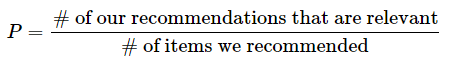

**Compared to Recall**
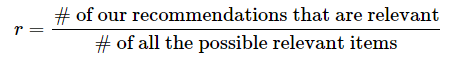

In [ ]:
from keras.metrics import AUC
from keras.metrics import Precision
from keras.metrics import Recall
from keras.optimizers import Adam

# Hyperparameter Tuning 

Bayesian Optimization Approach:
https://neptune.ai/blog/keras-tuner-tuning-hyperparameters-deep-learning-model

In [ ]:
!pip install -q -U keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def build_model(hp):
  # create model
  model = Sequential()

  # Define input layer, and first hidden layer
  # neurons for first hidden layer
  model.add(Dense(hp.Int('first layer', 
                                   min_value =20, 
                                   max_value = 1000,
                                   step = 50), input_dim=num_features, activation='relu')
  )

  # Define 2nd hidden (Dense) layers onward
  # Tune layers, neurons
  for i in range(hp.Int('num_layers', 2, 20)):
      model.add(Dense(units=hp.Int('units_' + str(i), 
                                   min_value =20, 
                                   max_value = 1000,
                                   step = 50),
                      activation='relu', 
                      name=f'Hidden{i}')
      )
      # Add drop out layers to 5th hidden layer
      if i == 4:
        model.add(Dropout(rate=0.25)
        )

  # Define output layer
  model.add(Dense(1, activation='sigmoid')
  )

  hp_learning_rate = hp.Choice('learning_rate', values=[0.2, 0.1, 1e-2, 1e-3, 1e-4])

  # Compile model
  # Tune learning rate at optimizer
  model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=hp_learning_rate), 
                  metrics=[AUC(),Precision(), Recall()]
                  )
  return model

# Hyperparameter Tuning using Random Search

In [ ]:
from kerastuner import Objective
from keras.callbacks import EarlyStopping

Try batch size = 500

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = Objective("val_loss", direction="min"),
     max_trials=20,
     directory='olddir_1') # each time you run random search, chnage directory name

stop_early = EarlyStopping(monitor='val_loss', patience=7)

tuner.search(x=X_train_trf1,
             y=y_train,
             batch_size = 500,
             epochs = 100,
             validation_data=(X_val_trf1, y_val)
             ,callbacks = [stop_early]
             )


Trial 20 Complete [00h 00m 26s]
val_loss: 0.6252050995826721

Best val_loss So Far: 0.5612913370132446
Total elapsed time: 00h 38m 18s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.hypermodel.build(tuner.get_best_hyperparameters()[0]).summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 720)               20160     
_________________________________________________________________
Hidden0 (Dense)              (None, 120)               86520     
_________________________________________________________________
Hidden1 (Dense)              (None, 570)               68970     
_________________________________________________________________
Hidden2 (Dense)              (None, 820)               468220    
_________________________________________________________________
Hidden3 (Dense)              (None, 120)               98520     
_________________________________________________________________
Hidden4 (Dense)              (None, 920)               111320    
_________________________________________________________________
dropout (Dropout)            (None, 920)               0

In [ ]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 720)               20160     
_________________________________________________________________
Hidden0 (Dense)              (None, 120)               86520     
_________________________________________________________________
Hidden1 (Dense)              (None, 570)               68970     
_________________________________________________________________
Hidden2 (Dense)              (None, 820)               468220    
_________________________________________________________________
Hidden3 (Dense)              (None, 120)               98520     
_________________________________________________________________
Hidden4 (Dense)              (None, 920)               111320    
_________________________________________________________________
dropout (Dropout)            (None, 920)               0

In [ ]:
best_model_rs = tuner.get_best_models()[0]

# After building a model against the training set, test that model
# against the val set.
result = best_model_rs.evaluate(x=X_val_trf1, 
                  y=y_val, 
                  batch_size=500)
for item in zip(best_model_rs.metrics_names, result):
  print (item[0], item[1])

83/83 [==============================] - 1s 4ms/step - loss: 0.5599 - auc: 0.7166 - precision: 0.6025 - recall: 0.2771
loss 0.5612913370132446
auc 0.7146475315093994
precision 0.597917377948761
recall 0.2729015052318573


In [ ]:
#best_model_rs.save('best_model_rs.h5')
best_model_rs = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_rs.h5')

Changing to Bayesian Optimization

In [ ]:
from kerastuner.tuners import BayesianOptimization

In [ ]:
class MyTuner(BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 100, 1000, step=150)
    kwargs['epochs'] = trial.hyperparameters.Int('epochs', 50, 130, step = 20)
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Uses same arguments as the BayesianOptimization Tuner.
tuner_bo = MyTuner(build_model,
    objective = Objective("val_loss", direction="min"),
            max_trials=10,
            seed=42,
            executions_per_trial=5)

stop_early = EarlyStopping(monitor='val_loss', patience=7)

# Don't pass epochs or batch_size here, let the Tuner tune them.
tuner_bo.search(x=X_train_trf1,
             y=y_train,
             validation_data=(X_val_trf1, y_val),
             callbacks = [stop_early]
             )

Trial 10 Complete [00h 06m 13s]
val_loss: 0.5652147173881531

Best val_loss So Far: 0.5622292995452881
Total elapsed time: 01h 42m 23s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_bo.get_best_hyperparameters()[0].values

{'batch_size': 1000,
 'epochs': 130,
 'first layer': 970,
 'learning_rate': 0.0001,
 'num_layers': 2,
 'units_0': 970,
 'units_1': 970,
 'units_10': 970,
 'units_11': 970,
 'units_2': 20,
 'units_3': 970,
 'units_4': 970,
 'units_5': 970,
 'units_6': 970,
 'units_7': 970,
 'units_8': 970,
 'units_9': 970}

In [ ]:
best_model_bo = tuner_bo.get_best_models()[0]

# After building a model against the training set, test that model
# against the val set.
result = tuner_bo.evaluate(x=X_val_trf1, 
                  y=y_val, 
                  batch_size=500) #set batch size from previous block of code manually
for item in zip(best_model_bo.metrics_names, result):
  print (item[0], item[1])

AttributeError: ignored

In [ ]:
best_hps_bo = tuner_bo.get_best_hyperparameters()[0]
best_model_bo = tuner_bo.hypermodel.build(best_hps_bo)
best_model_bo.summary() # equivalent to tuner_bo.get_best_models()[0].summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 970)               27160     
_________________________________________________________________
Hidden0 (Dense)              (None, 970)               941870    
_________________________________________________________________
Hidden1 (Dense)              (None, 970)               941870    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 971       
Total params: 1,911,871
Trainable params: 1,911,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Export your models & weights. Remember to download them from the folder tab on the left
best_model_bo.save('best_model_bo.h5')
#best_model_bo = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_bo.h5').summary()

# Choose Neural Network based on validation precision

**Random Search Model**


In [ ]:
# Import your models 

best_model_rs = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_rs.h5')

NameError: ignored

In [ ]:
# The following variables are the hyperparameters.
lr = 0.01
epochs = 80
batch_size = 500


# Train the best model from  Random Search on training set.
hist = train_model(best_model_rs, X_train_trf1, y_train, 
                   X_val_trf1, y_val, 
                   epochs, batch_size)


Epoch 1/80
466/466 [==============================] - 11s 17ms/step - loss: 0.5469 - auc: 0.7349 - precision: 0.6090 - recall: 0.3351 - val_loss: 0.5629 - val_auc: 0.7140 - val_precision: 0.5736 - val_recall: 0.3172
Epoch 2/80
466/466 [==============================] - 7s 15ms/step - loss: 0.5466 - auc: 0.7354 - precision: 0.6090 - recall: 0.3334 - val_loss: 0.5644 - val_auc: 0.7125 - val_precision: 0.5610 - val_recall: 0.3680
Epoch 3/80
466/466 [==============================] - 7s 15ms/step - loss: 0.5462 - auc: 0.7358 - precision: 0.6110 - recall: 0.3298 - val_loss: 0.5629 - val_auc: 0.7139 - val_precision: 0.5774 - val_recall: 0.3132
Epoch 4/80
466/466 [==============================] - 7s 15ms/step - loss: 0.5455 - auc: 0.7367 - precision: 0.6128 - recall: 0.3281 - val_loss: 0.5652 - val_auc: 0.7114 - val_precision: 0.5687 - val_recall: 0.3395
Epoch 5/80
466/466 [==============================] - 7s 15ms/step - loss: 0.5455 - auc: 0.7368 - precision: 0.6082 - recall: 0.3409 - val_

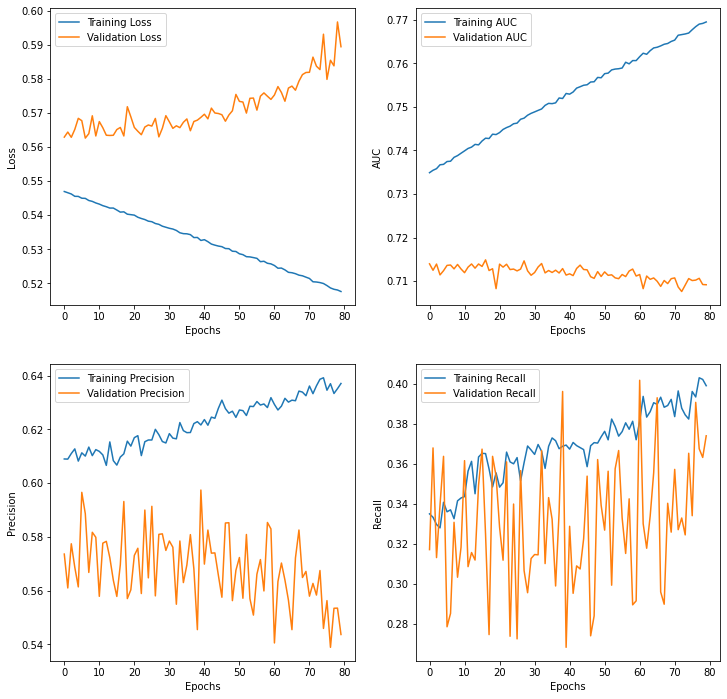

In [ ]:
# Plot a graph of the metric vs. epochs.
plot_curve(hist)

In [ ]:
# After building a model against the training set, test that model
# against the test set.
result = best_model_rs.evaluate(x=X_test_trf1, 
                  y=y_test, 
                  batch_size=batch_size)

for item in zip(best_model_rs.metrics_names, result):
  print(item[0], item[1])

137/137 [==============================] - 1s 8ms/step - loss: 0.5886 - auc: 0.7125 - precision: 0.5539 - recall: 0.3823
loss 0.5886018872261047
auc 0.7124671339988708
precision 0.5539424419403076
recall 0.38227859139442444


**Bayesian Optimized Model**

In [ ]:
#Import Model

best_model_bo = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/best_model_bo.h5')

In [ ]:
# The following variables are the hyperparameters.
lr = 0.01
epochs = 80
batch_size = 500


# Train the best model from  Random Search on training set.
hist = train_model(best_model_bo, X_train_trf1, y_train, 
                   X_val_trf1, y_val, 
                   epochs, batch_size)


Epoch 1/80
466/466 [==============================] - 4s 7ms/step - loss: 0.5959 - auc: 0.6454 - precision: 0.5789 - recall: 0.1149 - val_loss: 0.5862 - val_auc: 0.6689 - val_precision: 0.6054 - val_recall: 0.1585
Epoch 2/80
466/466 [==============================] - 3s 6ms/step - loss: 0.5841 - auc: 0.6721 - precision: 0.5939 - recall: 0.1826 - val_loss: 0.5817 - val_auc: 0.6775 - val_precision: 0.6102 - val_recall: 0.1762
Epoch 3/80
466/466 [==============================] - 3s 6ms/step - loss: 0.5795 - auc: 0.6813 - precision: 0.5916 - recall: 0.2016 - val_loss: 0.5790 - val_auc: 0.6853 - val_precision: 0.5759 - val_recall: 0.2534
Epoch 4/80
466/466 [==============================] - 3s 6ms/step - loss: 0.5767 - auc: 0.6863 - precision: 0.5988 - recall: 0.2145 - val_loss: 0.5760 - val_auc: 0.6888 - val_precision: 0.6073 - val_recall: 0.1950
Epoch 5/80
466/466 [==============================] - 3s 6ms/step - loss: 0.5747 - auc: 0.6901 - precision: 0.5968 - recall: 0.2262 - val_loss: 

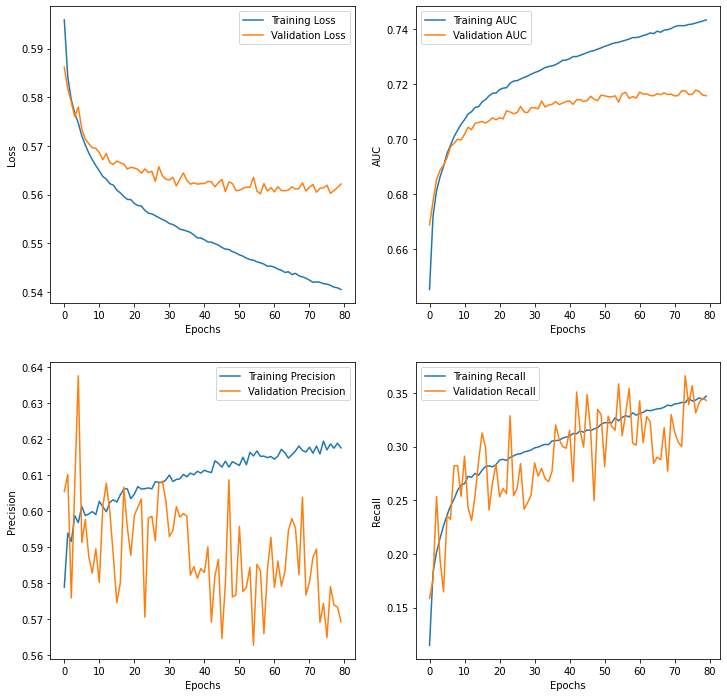

In [ ]:
# Plot a graph of the metric vs. epochs.
plot_curve(hist)

In [ ]:
# After building a model against the training set, test that model
# against the test set.
result = best_model_bo.evaluate(x=X_test_trf1, 
                  y=y_test, 
                  batch_size=batch_size)

for item in zip(best_model_bo.metrics_names, result):
  print(item[0], item[1])

137/137 [==============================] - 1s 4ms/step - loss: 0.5617 - auc: 0.7169 - precision: 0.5792 - recall: 0.3461
loss 0.5616964101791382
auc 0.7169485092163086
precision 0.5792185664176941
recall 0.34610965847969055


# Tweak decision threshold

In [ ]:
from sklearn.metrics import precision_score
def get_precision_score(threshold, y_true, x_true, model):
  preds = model.predict(x_true)
  preds[preds >= threshold] = 1
  preds[preds < threshold] = 0
  return precision_score(y_true, preds)

get_precision_score(threshold = 0.8, y_true = y_val, x_true = X_val_trf1, model = best_model_rs)

0.680365296803653

In [ ]:
get_precision_score(threshold = 0.8, y_true = y_test, x_true = X_test_trf1, model = best_model_rs)

0.6746113989637306

# Make recommendation

In [ ]:
X_test_complete.shape

(73742, 2)

In [ ]:
def show_recommendation(model, X_features_complete, X_trf1,
                        threshold):
  prediction = model.predict(X_trf1) # probabilities
  prediction[prediction >= threshold] = 1
  prediction[prediction< threshold] = 0
  prediction_ser = pd.DataFrame(prediction,
                                columns = ['Reccomend?'])

  # Combine
  movie_user = pd.concat([X_features_complete,prediction_ser], axis=1)

  # show primaryTitle, userID_ori & reccomend or not
  return movie_user.loc[movie_user['Reccomend?'] == 1]

show_recommendation(best_model_rs, X_test_complete, X_test_trf1,
                        0.8)

,primaryTitle,userId_ori,userId,Reccomend?
12,Black Beauty,9620,0.048965,1.0
111,Die Hard,106507,0.651616,1.0
116,Hud,90691,0.553238,1.0
119,Taxi Driver,18995,0.107279,1.0
123,Fargo,103611,0.633602,1.0
...,...,...,...,...
68159,Rosemary's Baby,11952,0.063470,1.0
68185,12 Angry Men,129711,0.795948,1.0
68214,Nixon,18995,0.107279,1.0
68291,Citizen Kane,30111,0.176422,1.0
